In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_images_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
image_size=299

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,  
    brightness_range=[0.8, 1.2], 
    rotation_range=15,  
    width_shift_range=0.2, 
    height_shift_range=0.2,
    fill_mode='nearest', 
    channel_shift_range=5.0,  
)


train_generator = train_datagen.flow_from_directory(
    train_images_dir, 
    target_size=(image_size, image_size),  
    batch_size=32,
    class_mode='categorical',  
    subset='training',
        shuffle=True, 
)

# Create the validation generator
validation_generator = train_datagen.flow_from_directory(
    train_images_dir, 
    target_size=(image_size, image_size),  
    batch_size=32,
    class_mode='categorical', 
    subset='validation', 
    shuffle=False, 
)


Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import os


image_size = 299  
batch_size = 32
epochs = 25
num_classes = 196 
learning_rate = 0.01

base_model = tf.keras.applications.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(image_size, image_size, 3)  

base_model.trainable = False

model = models.Sequential([
    base_model, =
    layers.GlobalAveragePooling2D(),  
    layers.Dense(1024, activation='relu'), 
    #layers.Dense(320, activation='relu'), 
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax') 
])
optimizer = optimizers.Adam(learning_rate=0.001) 

for layer in base_model.layers[-20:]:
    layer.trainable = True
    
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size, 
    validation_steps=validation_generator.samples // batch_size, 
    #callbacks=[ checkpoint_callback]  # Include the callbacks
)


Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.0103 - loss: 5.1760 - val_accuracy: 0.0599 - val_loss: 4.4804
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1250 - loss: 3.9934 - val_accuracy: 0.1000 - val_loss: 4.2410
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 205s 968ms/step - accuracy: 0.0758 - loss: 3.9494 - val_accuracy: 0.1432 - val_loss: 3.4685
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.0625 - loss: 3.6922 - val_accuracy: 0.7000 - val_loss: 1.5116
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 207s 979ms/step - accuracy: 0.1820 - loss: 3.0714 - val_accuracy: 0.2493 - val_loss: 2.7240
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.1875 - loss: 2.8764 - val_accuracy: 0.4000 - val_loss: 1.9234
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 207s 976ms/step - accuracy: 0.3263 - loss: 2.3443 - val_accuracy: 0.3594 - val_loss: 2.3277
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.2188 - loss: 2.4659

In [ ]:
model.load_weights(os.path.join(save_dir, 'best_weights.keras.weights.h5'))


In [6]:
test_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False  
)

Found 8041 images belonging to 196 classes.


In [7]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


251/251 ━━━━━━━━━━━━━━━━━━━━ 60s 240ms/step - accuracy: 0.6972 - loss: 1.1539
Test Loss: 1.029304027557373
Test Accuracy: 0.7373008131980896


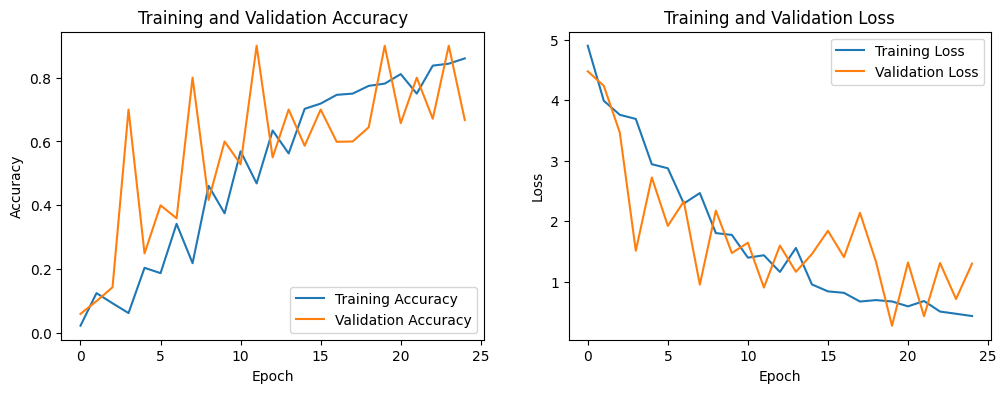

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 804ms/step


<Figure size 800x600 with 0 Axes>

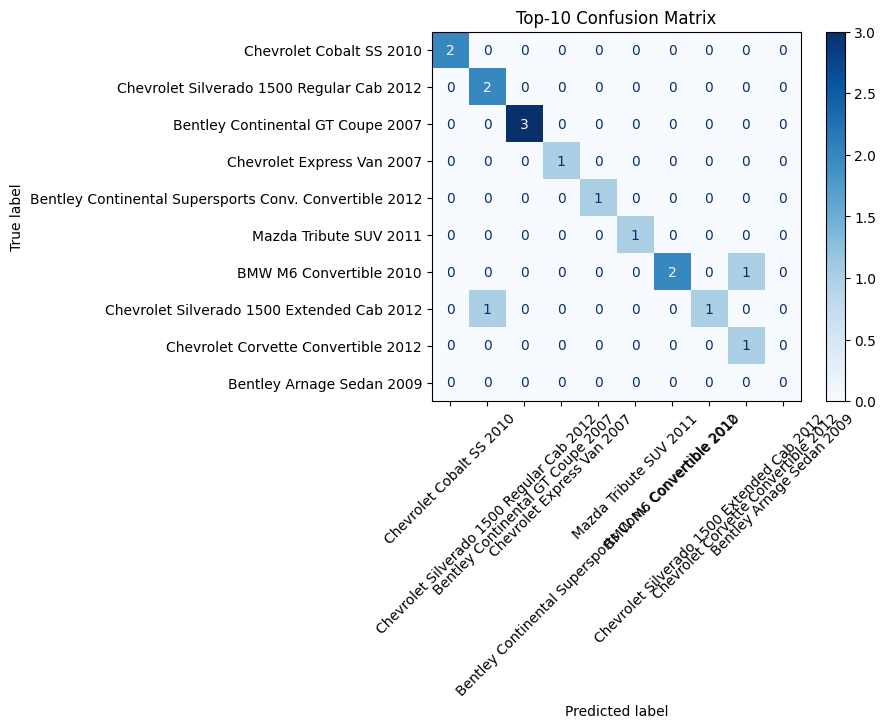

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get Ground Truth Labels and Predictions
Y_true = validation_generator.classes  # Ground truth
Y_pred = model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Sum of misclassifications per class
misclassifications = np.sum(cm, axis=1) - np.diag(cm)

# Select Top-K Classes with Most Misclassifications
K = 10
top_k_classes = np.argsort(misclassifications)[-K:]

# Create Reduced Confusion Matrix
cm_reduced = cm[np.ix_(top_k_classes, top_k_classes)]
class_labels = np.array(list(validation_generator.class_indices.keys()))[top_k_classes]

# Display Reduced Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reduced, display_labels=class_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title(f"Top-{K} Confusion Matrix")
plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 771ms/step


<Figure size 800x600 with 0 Axes>

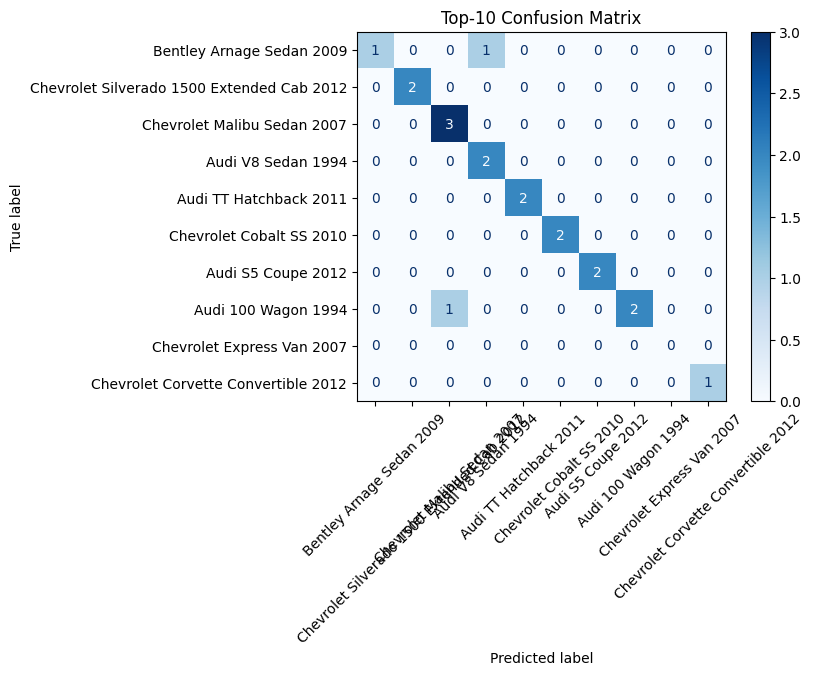

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get Ground Truth Labels and Predictions
Y_true = validation_generator.classes  # Ground truth
Y_pred = model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Sum of misclassifications per class
misclassifications = np.sum(cm, axis=1) - np.diag(cm)

# Select Top-K Classes with Most Misclassifications
K = 10
top_k_classes = np.argsort(misclassifications)[-K:]

# Create Reduced Confusion Matrix
cm_reduced = cm[np.ix_(top_k_classes, top_k_classes)]
class_labels = np.array(list(validation_generator.class_indices.keys()))[top_k_classes]

# Display Reduced Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reduced, display_labels=class_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title(f"Top-{K} Confusion Matrix")
plt.show()


In [11]:
from sklearn.metrics import classification_report

# Generate Classification Report
print("Classification Report:\n")
report = classification_report(Y_true, Y_pred_classes, target_names=validation_generator.class_indices.keys())
print(report)


Classification Report:

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       1.00      0.89      0.94         9
                             Acura Integra Type R 2001       0.80      0.89      0.84         9
                                   Acura RL Sedan 2012       0.50      0.33      0.40         6
                                   Acura TL Sedan 2012       0.70      0.88      0.78         8
                                  Acura TL Type-S 2008       1.00      0.62      0.77         8
                                  Acura TSX Sedan 2012       0.38      0.62      0.48         8
                              Acura ZDX Hatchback 2012       0.71      0.71      0.71         7
              Aston Martin V8 Vantage Convertible 2012       0.31      0.44      0.36         9
                    Aston Martin V8 Vantage Coupe 2012       0.71      0.62      0.67         8
               

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


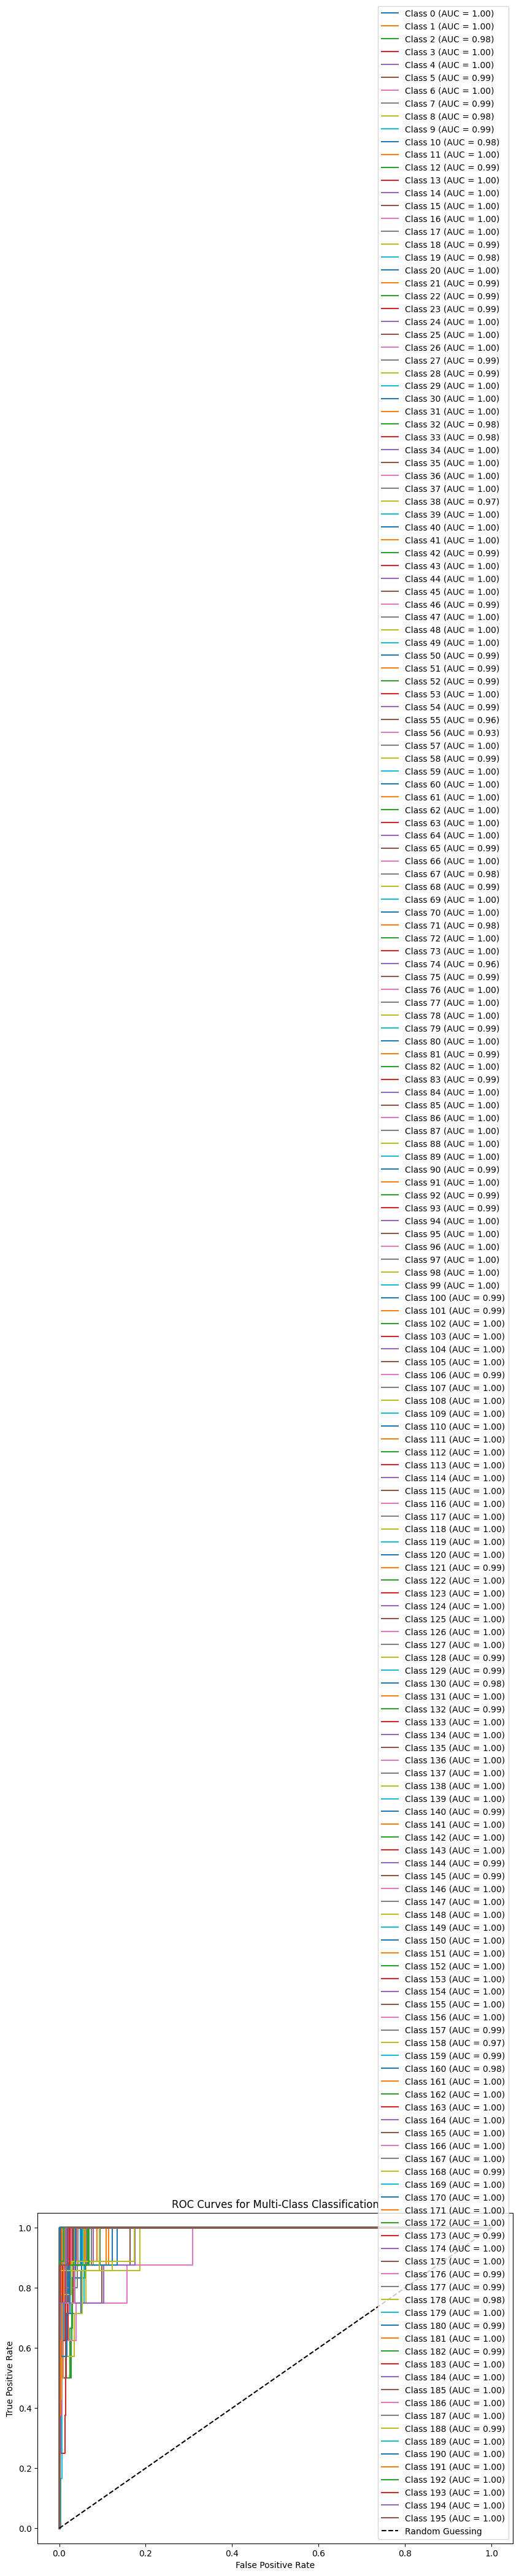

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
n_classes = len(validation_generator.class_indices)
Y_true_bin = label_binarize(Y_true, classes=[i for i in range(n_classes)])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()
